# Analysis of Recurion's 2019a HRCE Dataset

**Author: Jason Inzana**

This analysis uses a subset of the [2019a dataset](https://www.rxrx.ai/rxrx19a) shared by Recursion and focuses on the HRCE cell data. I was inspired to tinker with this data as a learning exercise after reading Recursion's [publication on this dataset](https://www.biorxiv.org/lookup/doi/10.1101/2020.04.21.054387). 

My goal was not to perfectly replicate the published work, but to use it as an initial guide and implement my own approach based on my current knowlege and understanding of HTS assays, phenomics, and drug discovery.

This analysis indicates that Remdesivir and its parent nucleoside, GS-441524, are the top 2 drug candidates, followed by trihexyphenidyl and Aloxistatin. Trihexyphenidyl only exhibited potential efficacy at the highest dose. Since there does appear to be some residual noise among the treatment data, it could be a false positive. The other 3 hits have multiple doses showing promise, and those molecules are consistent with Recursion's findings.

Other normalization methods may be more effective at reducing noise among the treatment data without significantly impairing the true signals. A few approaches to consider will be:
- Alternative approaches to the median polish method, and/or addition of well correction
    - Performing the polish plate-wise rather than using the "median plate" as a bias template. This may risk extinguishing true signals though.
- Linear mixed effects model similar to that described by [Yu et al.](https://pubmed.ncbi.nlm.nih.gov/21685046/)
- Empirical Bayes approach similar to that described by [Zhang et al.](https://pubmed.ncbi.nlm.nih.gov/18628291/)
    - Option 1: Just use the Disease control to construct the prior
    - Option 2: Use both the Disease and Healthy controls to construct the prior as a mixture distribution 


# Import Libraries and Data

In [153]:
# Import libraries
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

from scipy import spatial
from scipy import stats
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.graphics import tsaplots

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Load in the dataset
features = pd.read_csv("/Volumes/GoogleDrive/My Drive/Colab Notebooks/Recursion COVID/embeddings.csv")
metadata = pd.read_csv("/Volumes/GoogleDrive/My Drive/Colab Notebooks/Recursion COVID/metadata.csv")


# Data Overview

## Overview of original metadata

In [154]:
metadata.head()

,site_id,well_id,cell_type,experiment,plate,well,site,disease_condition,treatment,treatment_conc,SMILES
0,HRCE-1_1_AA02_1,HRCE-1_1_AA02,HRCE,HRCE-1,1,AA02,1,Active SARS-CoV-2,Flubendazole,0.1,COC(=O)NC1=NC2=C(N1)C=C(C=C2)C(=O)C1=CC=C(F)C=...
1,HRCE-1_1_AA02_2,HRCE-1_1_AA02,HRCE,HRCE-1,1,AA02,2,Active SARS-CoV-2,Flubendazole,0.1,COC(=O)NC1=NC2=C(N1)C=C(C=C2)C(=O)C1=CC=C(F)C=...
2,HRCE-1_1_AA02_3,HRCE-1_1_AA02,HRCE,HRCE-1,1,AA02,3,Active SARS-CoV-2,Flubendazole,0.1,COC(=O)NC1=NC2=C(N1)C=C(C=C2)C(=O)C1=CC=C(F)C=...
3,HRCE-1_1_AA02_4,HRCE-1_1_AA02,HRCE,HRCE-1,1,AA02,4,Active SARS-CoV-2,Flubendazole,0.1,COC(=O)NC1=NC2=C(N1)C=C(C=C2)C(=O)C1=CC=C(F)C=...
4,HRCE-1_1_AA03_1,HRCE-1_1_AA03,HRCE,HRCE-1,1,AA03,1,Active SARS-CoV-2,acetylcysteine,1.0,"CC(=O)N[C@H](CS)C(O)=O |a:4,r|"


## Overview of original feature data

In [155]:
features.head()

,site_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_1014,feature_1015,feature_1016,feature_1017,feature_1018,feature_1019,feature_1020,feature_1021,feature_1022,feature_1023
0,HRCE-1_10_AA02_1,2.355969,-0.058361,-0.169764,-0.316499,-0.891334,0.581174,-0.284587,-0.279198,-0.146575,...,0.391186,0.786199,-1.739626,-1.317543,-1.208275,-0.507439,-0.317298,0.285018,-0.091285,-1.553895
1,HRCE-1_10_AA02_2,2.325652,-0.202519,-0.296017,-0.481136,-0.641461,0.702847,0.334191,-0.077498,-0.314538,...,0.638674,1.051621,-1.355659,-1.285210,-1.341911,-0.271349,-0.157707,0.081128,-0.447174,-1.614872
2,HRCE-1_10_AA02_3,2.207082,-0.379794,-0.365562,-0.196667,-0.799039,0.735813,0.081227,-0.393452,0.066324,...,0.552127,0.775428,-1.616731,-0.868382,-1.334486,-0.774456,-0.363250,0.161023,-0.066745,-1.325545
3,HRCE-1_10_AA02_4,2.452741,0.050658,-0.444642,-0.309758,-0.724900,0.658327,-0.128331,-0.164759,0.279105,...,0.689145,1.167066,-1.275786,-2.088455,-1.231964,-0.364454,-0.135066,0.493010,-0.544680,-1.290150
4,HRCE-1_10_AA03_1,2.106868,0.032095,-0.175542,-0.808618,-0.806217,0.721340,-0.213196,-0.187649,-0.070294,...,0.385696,0.503924,-1.192554,-1.123965,-1.323457,-0.359761,-0.100340,0.185773,-0.394267,-1.712760


## Value counts for each cell type, experiment, and disease condition

In [156]:
metadata[['cell_type', 'experiment', 'disease_condition']].value_counts()

cell_type  experiment  disease_condition        
HRCE       HRCE-2      Active SARS-CoV-2            132776
           HRCE-1      Active SARS-CoV-2            127920
VERO       VERO-1      Active SARS-CoV-2              9840
           VERO-2      Active SARS-CoV-2              9840
HRCE       HRCE-2      Mock                           4320
                       UV Inactivated SARS-CoV-2      4320
           HRCE-1      Mock                           4160
                       UV Inactivated SARS-CoV-2      4160
VERO       VERO-1      Mock                            320
                       UV Inactivated SARS-CoV-2       320
           VERO-2      Mock                            320
                       UV Inactivated SARS-CoV-2       320
dtype: int64

# Initial Data Preparation


In this section, I do some simple data preparation:
- Drop VERO data to focus on HRCE cell data only
- Reduce the measurements to 1 measurement per well by averaging over the 4 sites in each well
- Rename the disease condition to simpler names (i.e., Active vs. Inactive)
- Extract row and column numbers from the well ID for 2D localization on a given plate
- Create a new metadata column "groups" to define the positive and negative control groups vs treated
- Create a new metadata column "samp_groups" to define each unique study group
- Setup the metadata as a multi-index on the features for cleaner code and easier slicing
- Setup some useful slicers that will be commonly used

In [157]:
# Just HRCE
metadata = metadata.loc[metadata.cell_type == 'HRCE',:].set_index('site_id') 
features = features.set_index('site_id').loc[metadata.index]

# Tidy the metadata; average features over the sites in each well to get 1 value per well
features = features.join(metadata.well_id)
metadata = metadata.groupby('well_id').first()
features = features.groupby('well_id').mean()

# Simplify the metadata and make it a bit easier to work with
metadata.disease_condition = metadata.disease_condition.replace({'UV Inactivated SARS-CoV-2': 'Inactive', 
                                                                 'Active SARS-CoV-2': 'Active'})
metadata.disease_condition.fillna('None', inplace=True)
metadata.treatment.fillna('None', inplace=True)
metadata.treatment_conc.fillna('None', inplace=True)
metadata.drop(['SMILES', 'site', 'cell_type'], axis=1, inplace=True)

# Decompose the well number into column and row labels
metadata = metadata.join(metadata['well'].str.extract('(?P<well_row>\D+)(?P<well_col>\d+)'))

# Relabel the rows with numbers instead of letters
rows = list(string.ascii_uppercase) + ['AA', 'AB', 'AC', 'AD', 'AE', 'AF']
row_dict = dict(zip(rows, range(1, len(rows)+1)))
metadata.well_row.replace(row_dict, inplace=True)
metadata[['well_col', 'well_row']] = metadata[['well_col', 'well_row']].astype(int)
metadata.drop(['well'], axis=1, inplace=True)

# Define Groups
metadata['group'] = np.select(
    [
    ((metadata.disease_condition=='Active') & (metadata.treatment=='None')),
    ((metadata.disease_condition=='Inactive')),
    ((metadata.disease_condition=='Active') & (metadata.treatment!='None')),
    ((metadata.disease_condition=='Mock')),
    ((metadata.disease_condition=='None')),
    ], 
    [
    'pos_ctrl',
    'neg_ctrl',
    'treated',
    'neg_ctrl_2',
    'none_ctrl'
    ], default=np.nan)


# Define sample groups of replicates within each experiment
samp_group = metadata.groupby(['experiment', 'disease_condition', 'treatment', 'treatment_conc'])\
                     .size().reset_index().reset_index().drop(0, axis=1)\
                     .rename({'index': 'samp_group'}, axis=1)
metadata = metadata.merge(samp_group, 
                          on=['experiment', 'disease_condition', 'treatment', 'treatment_conc'], 
                          how='left')\
                   .set_index(features.index)

# Consolidate metadata and features into a single dataframe and setup multi-index
df = features.join(metadata).set_index(list(metadata.columns), append=True)
idx_order = ['group', 'plate', 'well_col', 'well_row', 'experiment', 'disease_condition', 'treatment', 'treatment_conc', 'samp_group', 'well_id']
df = df.reorder_levels(idx_order)
idx = pd.IndexSlice

# Define some useful slicers
pos_ctrl = idx['pos_ctrl',:,:,:,:,:,:,:,:,:]
neg_ctrl = idx['neg_ctrl',:,:,:,:,:,:,:,:,:]
neg_ctrl_2 = idx['neg_ctrl_2',:,:,:,:,:,:,:,:,:]
treated = idx['treated',:,:,:,:,:,:,:,:,:]
main_ctrls = idx[['neg_ctrl', 'pos_ctrl'],:,:,:,:,:,:,:,:,:]
all_active = idx[:,:,:,:,:, 'Active',:,:,:,:]
exp1 = idx[:,:,:,:, 'HRCE-1',:,:,:,:,:]
exp2 = idx[:,:,:,:, 'HRCE-2',:,:,:,:,:]

# Exploratory Data Analysis

## Check if there is correlation between features
- Randomly selected 100 features to look at
- Positive and negative correlations are evident among features, suggesting the feature space can be reduced effectively with PCA

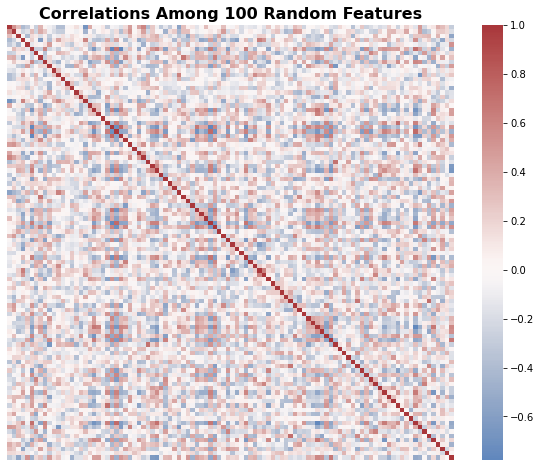

In [159]:
plt.figure(figsize=(10,8));
sns.heatmap(df.sample(n=100, random_state=0, axis=1).corr(), 
            cmap='vlag', 
            center=0);
plt.title('Correlations Among 100 Random Features', 
          fontdict={'weight':'bold', 'size':16});
plt.axis('off');

## Visualize the distribution of controls on the plates
- It looks like the negative controls (cyan, magenta, blue) are not randomized within each plate and the positive controls (red) are never in the same column as negative controls.
- Positive controls (red) are randomized among treated wells (green)

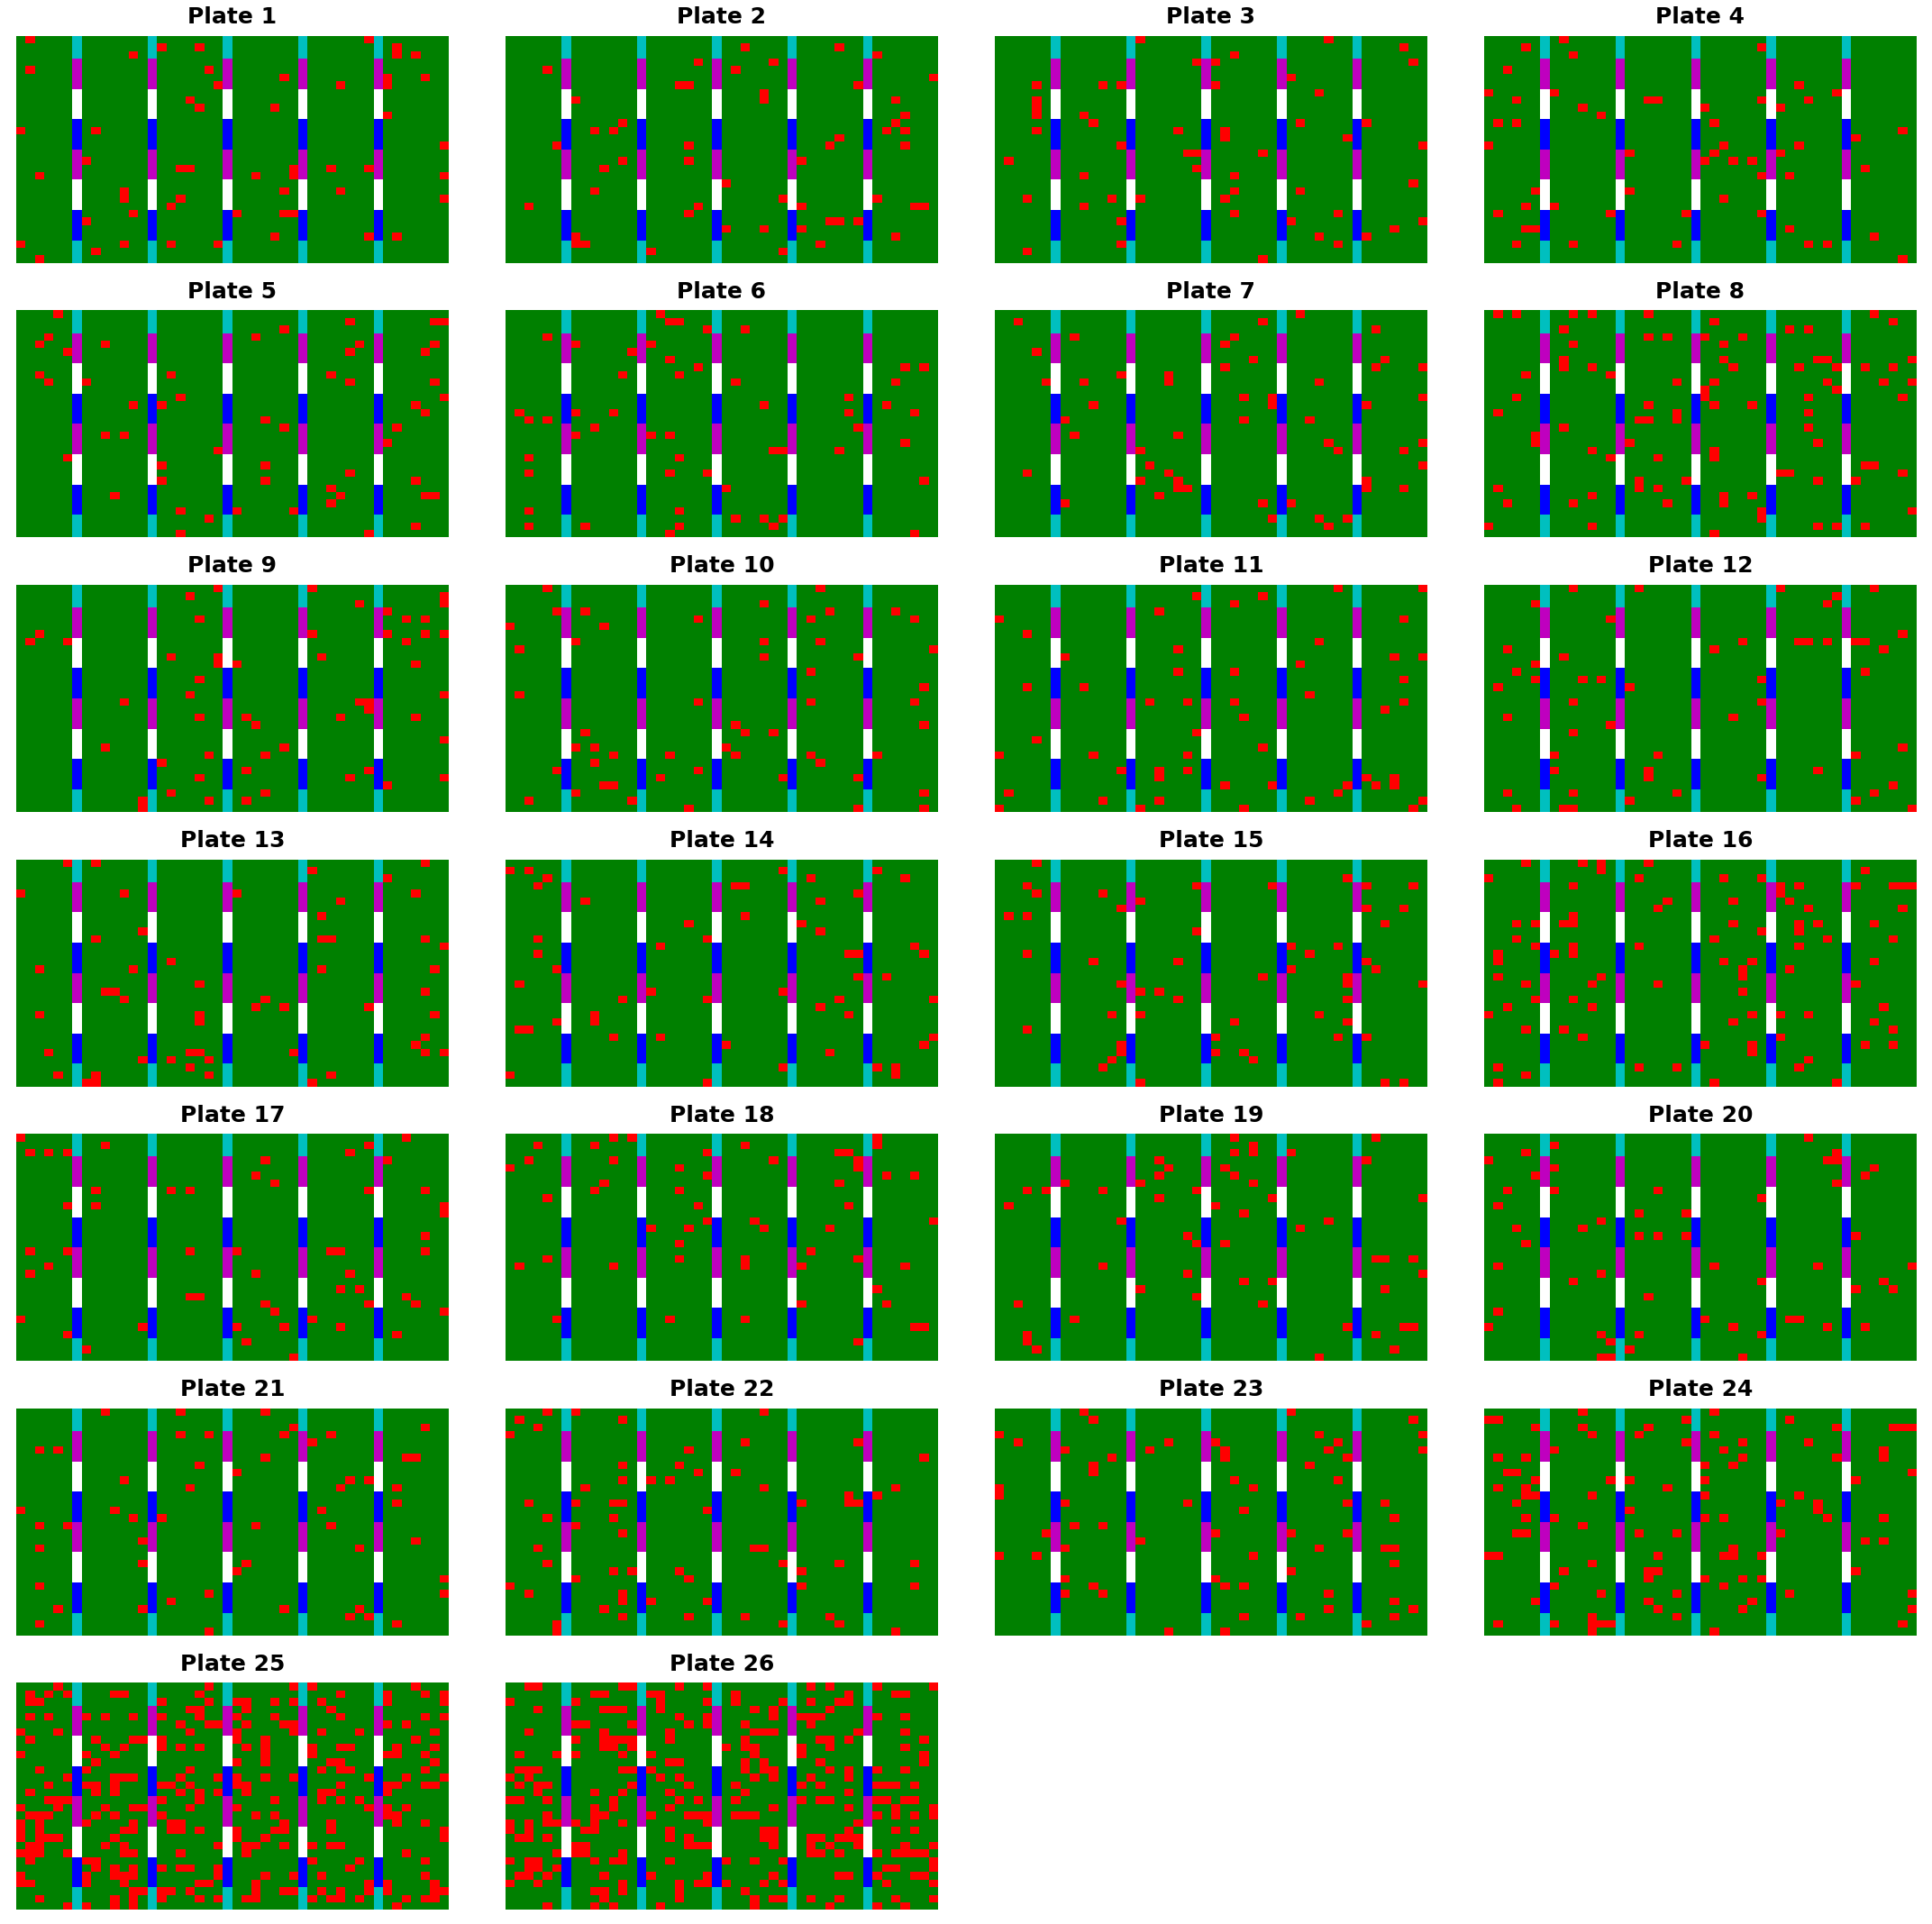

In [160]:
data = metadata[metadata.experiment=='HRCE-1']

_, ax = plt.subplots(7,4, figsize=(30,30))
for ii, curr_ax in enumerate(ax.reshape(-1)):
  ii += 1
  platedata = pd.DataFrame(np.zeros([32,48]), index=range(1,33), columns=range(1,49))
  plt.sca(curr_ax)
  plt.axis('off')
  
  if ii in data.plate.unique():
    currdata = data.loc[data.plate == ii]\
                   .pivot(index='well_row', columns='well_col', values='group')\
                   .replace({'pos_ctrl':2, 'treated':1, 'neg_ctrl':-1, 'neg_ctrl_2':-2, 'none_ctrl':-3})\
                   .fillna(0)
    platedata.loc[currdata.index, currdata.columns] = currdata
    sns.heatmap(platedata, 
                cmap=['c', 'm', 'b', 'w', 'g', 'r'], 
                cbar=False, 
                xticklabels=True, 
                yticklabels=True)
    plt.title('Plate {}'.format(ii), 
              fontdict={'weight': 'bold', 'size':25});    
    plt.tight_layout()


## Examine the control distributions for a couple of features
- Generally, distributions within each plate are approximately bell-shaped (normal) with a few exceptions, suggesting there may be differences or systematic bias between and/or within plates
- Plate 25 (2nd from right) looks concerning - quality issue here?

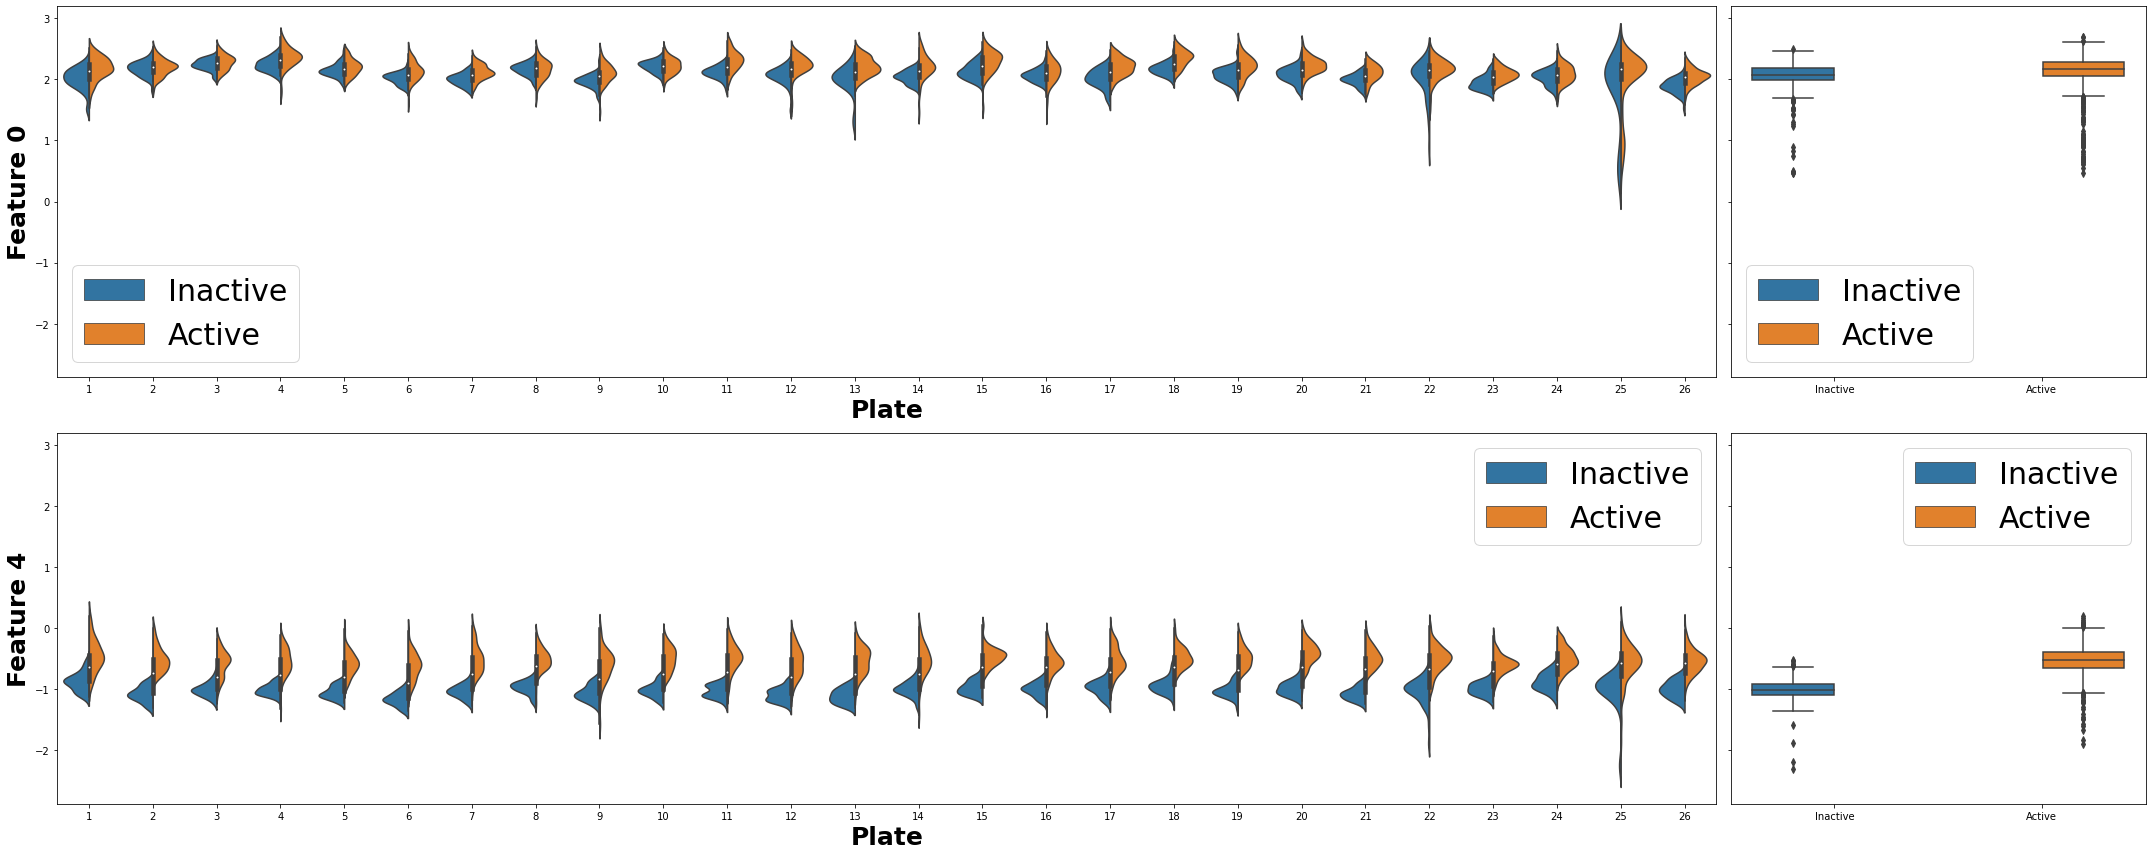

In [161]:
data=df.loc[exp1,:].loc[main_ctrls,:]

_, ax = plt.subplots(2,2, 
                     figsize=(30,12), 
                     gridspec_kw={'width_ratios': [4, 1]}, 
                     sharey=True)

labels = ['Feature 0', 'Feature 4']

for ii, feature in enumerate(['feature_0', 'feature_4']):

    plt.sca(ax[ii,0])
    sns.violinplot(x='plate', 
                   y=feature, 
                   hue='disease_condition',
                   split=True, 
                   data=data.reset_index())
    plt.ylabel(labels[ii], 
               fontdict={'weight': 'bold', 'size':25});
    plt.xlabel('Plate', 
               fontdict={'weight': 'bold', 'size':25});
    plt.legend(prop={'size': 30});

    plt.sca(ax[ii,1])
    sns.boxplot(x='disease_condition', 
                y=feature, 
                hue='disease_condition', 
                data=data.reset_index())
    plt.legend(prop={'size': 30});
    plt.ylabel('')
    plt.xlabel('')

plt.tight_layout()

## Visualize feature space of controls in 2D using t-SNE
- It looks like there is some clustering related to the plate and there are certainly batch effects between experiments
- Some of the Active (diseased) positive control wells seem to cluster with the Inactive (healthy) negative control wells - perhaps the viral infection was not successful in those wells? Anomalies to be removed?

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


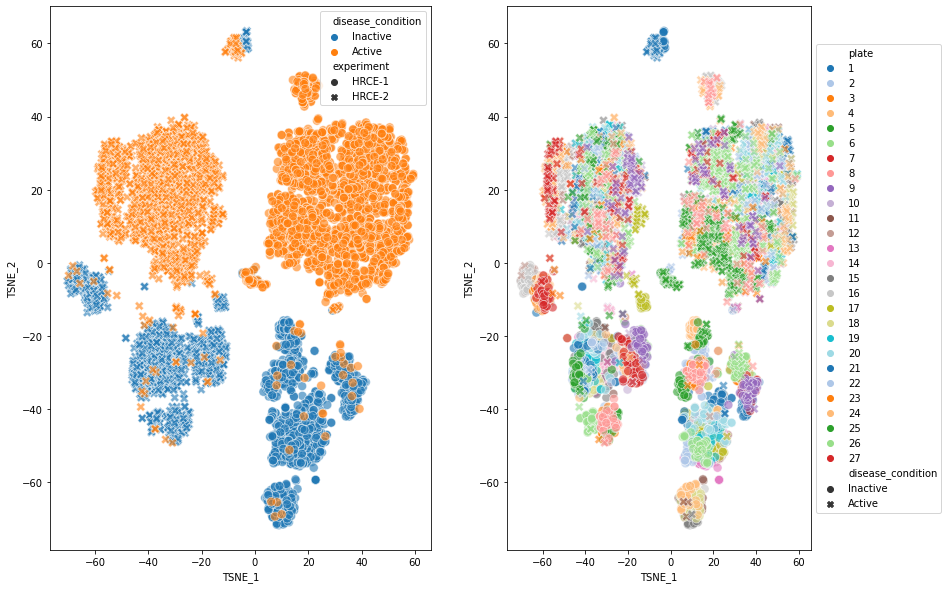

In [162]:
tsne = TSNE(init='pca', learning_rate='auto')
data = tsne.fit_transform(df.loc[main_ctrls,:])
data = pd.DataFrame(data, 
                    index=df.loc[main_ctrls].index, 
                    columns=['TSNE_1', 'TSNE_2'])

_, ax = plt.subplots(1,2, figsize=(15,10))

plt.sca(ax[0])
sns.scatterplot(x='TSNE_1', y='TSNE_2', 
                hue='disease_condition', style='experiment', 
                s=80, alpha=0.6, 
                data=data.reset_index())

plt.sca(ax[1])
sns.scatterplot(x='TSNE_1', y='TSNE_2', 
                hue='plate', palette='tab20', style='disease_condition', 
                s=80, alpha=0.6, 
                data=data.reset_index())

box = ax[1].get_position();
ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height]);
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5));

## Examine autocorrelations by well row and column
- There are some significant autocorrelations for the positive controls and All Active wells (positive controls plus treated wells) that suggest there may be spatial bias (rows / columns) on the plate

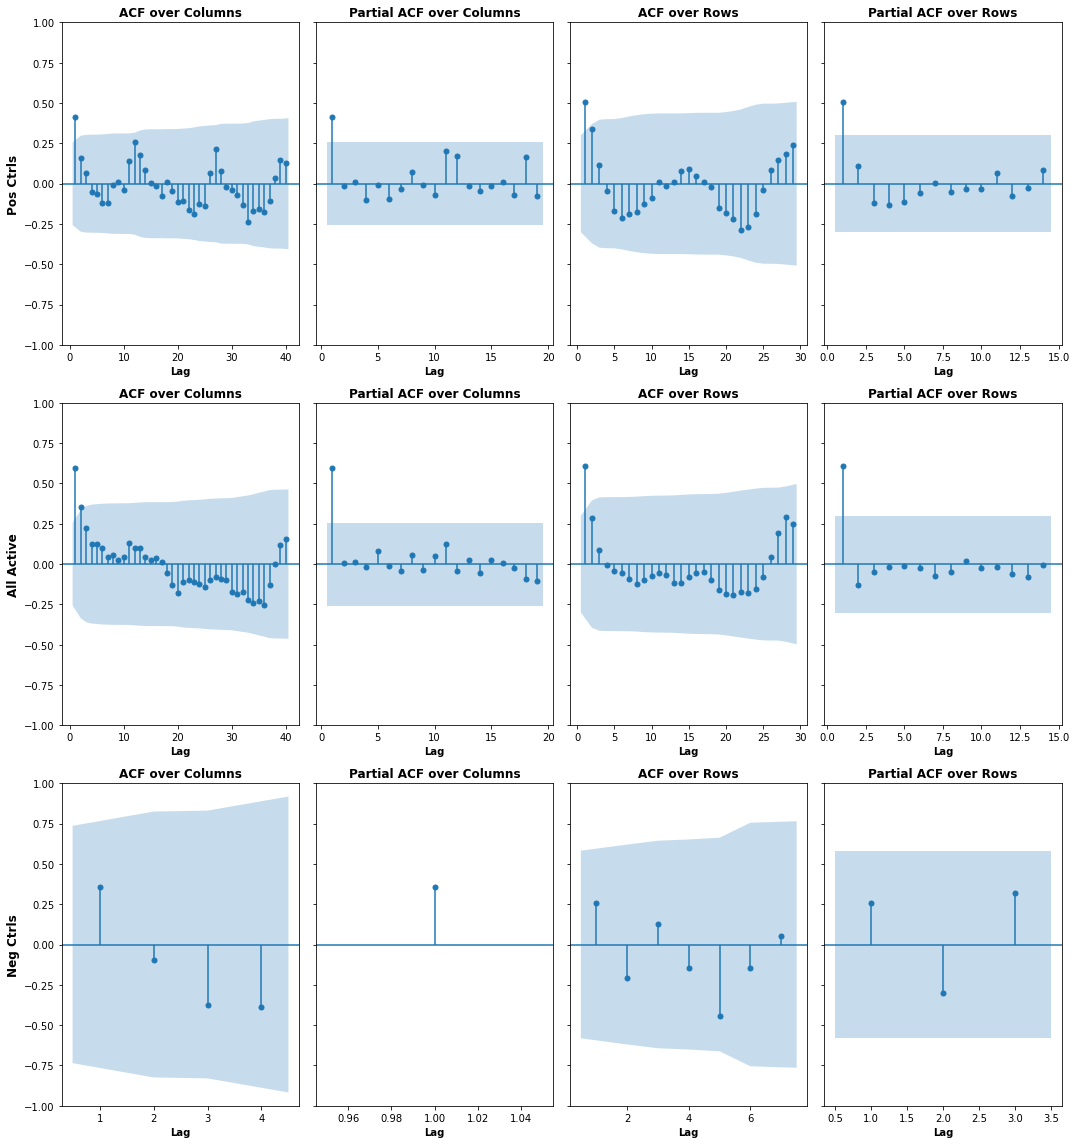

In [163]:
feat = 'feature_0'

groups = [pos_ctrl, all_active, neg_ctrl]
group_labels = ['Pos Ctrls', 'All Active', 'Neg Ctrls']
directions = ['well_col', 'well_row']
direction_labels = ['Columns', 'Rows']

fig, ax = plt.subplots(len(groups), len(directions)*2, 
                       figsize=(len(groups)*5, len(directions)*8), 
                       sharey=True)

for ii, (group, group_lab) in enumerate(zip(groups, group_labels)):
    for jj, (direction, dir_lab) in enumerate(zip(directions, direction_labels)):
                     
        data = df.loc[group,:].loc[exp1,:]\
                 .groupby(level=direction).median()
        
        tsaplots.plot_acf(data.loc[:,feat], 
                          zero=False, 
                          lags=data.shape[0]-1,
                          ax = ax[ii, jj*2],
                          alpha=0.1);
        plt.sca(ax[ii, jj*2])
        plt.ylim(-1,1);
        plt.xlabel('Lag', 
                   fontdict={'weight':'bold'})
        plt.title('ACF over ' + dir_lab, 
                  fontdict={'weight':'bold'})
        
        tsaplots.plot_pacf(data.loc[:,feat], 
                          zero=False, 
                          lags=data.shape[0]//2-1,
                          ax = ax[ii, jj*2+1],
                          alpha=0.1,
                          method='ywm');
        plt.sca(ax[ii, jj*2+1])
        plt.ylim(-1,1);
        plt.title('Partial ACF over ' + dir_lab, 
                  fontdict={'weight':'bold'})
        plt.xlabel('Lag', 
                   fontdict={'weight':'bold'})
        
    ax[ii,0].set_ylabel(group_lab, 
                        size='large', 
                        weight='bold')

fig.tight_layout()

## Plot the distribution of feature values within each group
- One specific treatment (Chloroquine) was selected to represent a treated sample that had large off-disease effects in Recursion's publication
- The 1024 features seem to be normally distributed with mean~0, within groups or randomly selected samples. Standardizing these feature distributions using quantile normalization within each replicated treatment or control group could be appropriate to help reduce variance

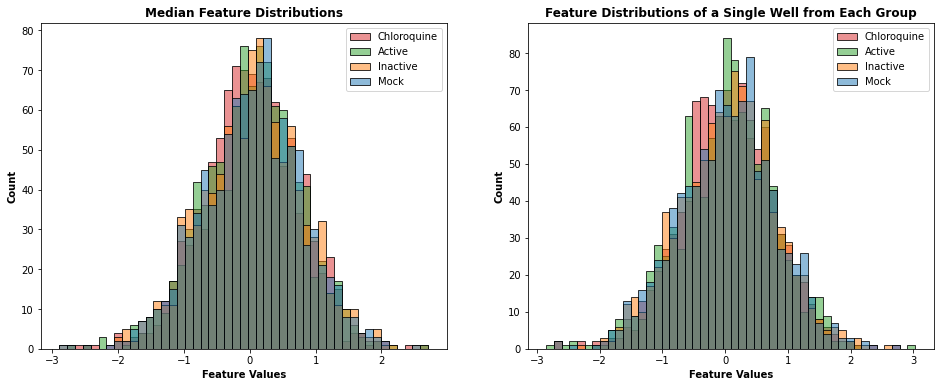

In [164]:
# Data representing median of each group
data = df.loc[exp1].groupby(level='group').median()
data.drop(['none_ctrl'], axis=0, inplace=True)
tx_data = df.xs(('Chloroquine', 10), level=['treatment', 'treatment_conc'])
data.loc['treated',:] = tx_data.median()
data = data.reset_index().melt(id_vars='group', value_vars=data.columns)

# Data representing a single sample from each group
data2 = df.loc[exp1].groupby(level='group').first()
data2.drop(['none_ctrl'], axis=0, inplace=True)
data2.loc['treated',:] = tx_data.iloc[0,:]
data2 = data2.reset_index().melt(id_vars='group', value_vars=data2.columns)

titles = ['Median Feature Distributions',
          'Feature Distributions of a Single Well from Each Group']     

_, ax = plt.subplots(1,2, figsize=(16,6))

iter = zip(ax, [data, data2], titles)     

for (curr_ax, curr_data, title) in iter:
  plt.sca(curr_ax)
  sns.histplot(x='value', 
               hue='group', 
               data=curr_data, 
               alpha=0.5);
  plt.title(title, 
            weight='bold');
  plt.ylabel('Count', 
             fontdict={'weight':'bold'});
  plt.xlabel('Feature Values', 
             fontdict={'weight':'bold'});
  plt.legend(['Chloroquine', 'Active', 'Inactive', 'Mock']);


# Normalization

## Plate Normalization
- Robust normalization of each plate based on the negative control

In [165]:
# Normalize each plate based on the negative control data

med_neg = df.loc[neg_ctrl].groupby(level=['experiment', 'plate']).median()
mad_neg = df.loc[neg_ctrl].groupby(level=['experiment', 'plate']).mad()
df = (df - med_neg) / mad_neg

df = df.reorder_levels(idx_order)

## Visualize the features on a plate format
- The "All Active" (right) plot certainly looks like there are some edge effects at least

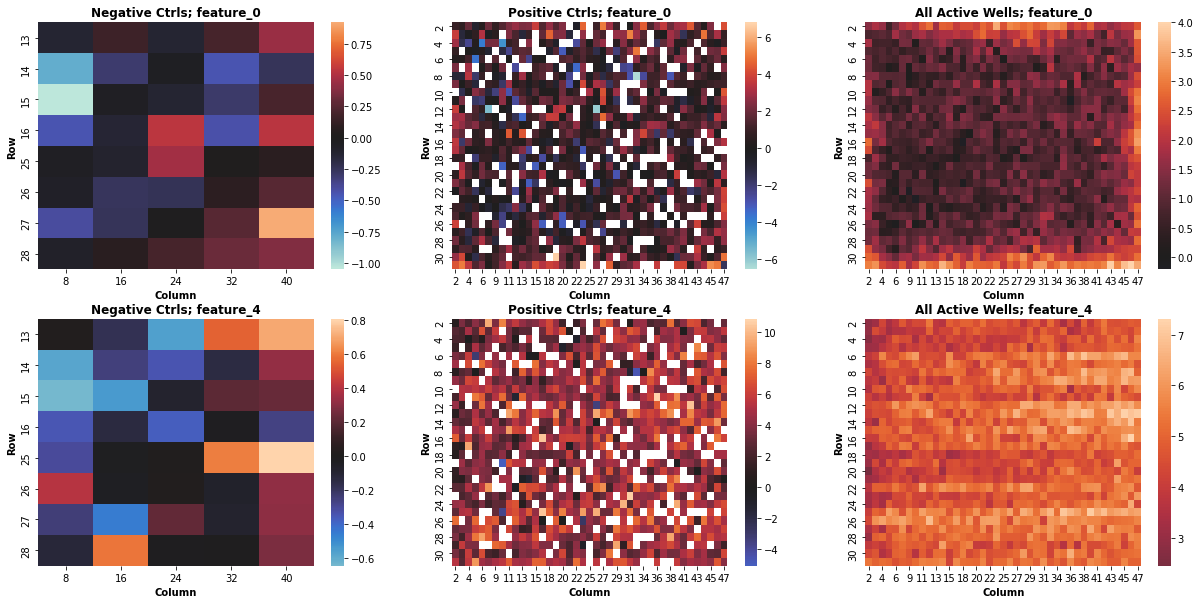

In [166]:
# Visualize the feature median on the plate
feats = ['feature_0', 'feature_4']
groups = [neg_ctrl, pos_ctrl, all_active]
labels = ['Negative Ctrls', 'Positive Ctrls', 'All Active Wells']
nf = len(feats)
ng = len(groups)

_, ax = plt.subplots(nf, ng, figsize=(7*ng,5*nf))

for ii, feat in enumerate(feats):
  for jj, (group, label) in enumerate(zip(groups, labels)):

    data = df.loc[group,:].loc[exp1,:].groupby(level=['well_row', 'well_col'])
    data = data[feat].median()
    data = data.reset_index().pivot(index='well_row', 
                                    columns='well_col', 
                                    values=feat)

    plt.sca(ax[ii,jj])
    sns.heatmap(data, center=0)
    plt.title(label + '; ' + feat, fontdict={'weight': 'bold'});
    plt.xlabel('Column', fontdict={'weight': 'bold'});
    plt.ylabel('Row', fontdict={'weight': 'bold'});


## Visualize the features across rows and columns for all Active wells
- There are clearly edge effects among some of the features
- There is also some oscillating and/or trending (e.g., feature_4 columns) variation across the rows/columns

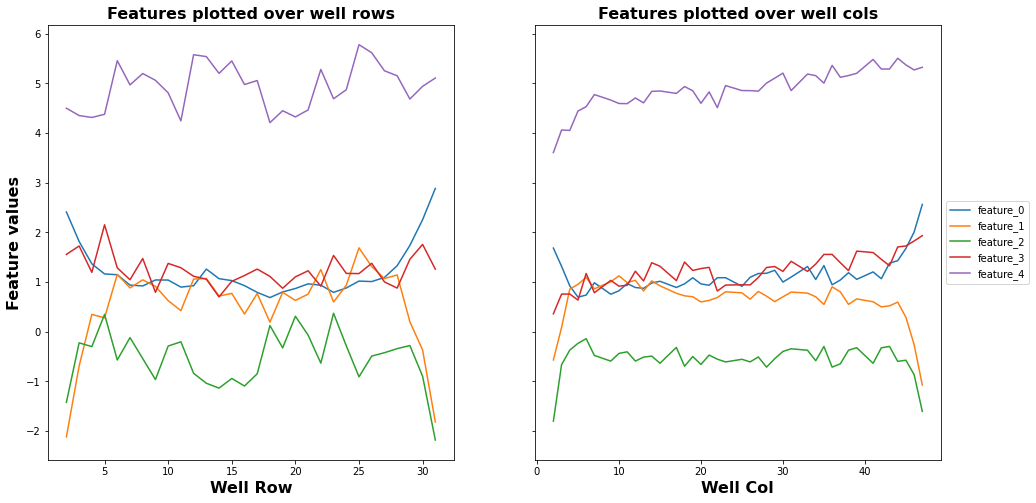

In [167]:
data = df.loc[exp1,:].loc[all_active,:]
groups = ['well_row', 'well_col']

data = data.groupby(level=groups).median()
_, ax = plt.subplots(1,2,figsize=(16,8), sharey=True)

for (curr_ax, group) in zip(ax, groups):

  plt.sca(curr_ax)
  feats = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4']
  data.loc[:,feats].groupby(level=group).median().plot.line(ax=curr_ax);
  plt.xlabel(group.replace('_', ' ').title(), 
             fontdict={'weight': 'bold', 'size': 16});
  plt.ylabel('Feature values', 
             fontdict={'weight': 'bold', 'size': 16});
  plt.title('Features plotted over ' + group.replace('_', ' ') + 's', 
            fontdict={'weight': 'bold', 'size': 16});
  curr_ax.get_legend().remove()

ax[-1].legend(loc='center left', 
             bbox_to_anchor=(1, 0.5));

## Remove systematic row/column bias
- Apply a median polish using the overall median plate as a spatial bias template, which will help avoid random effects that exist on any one plate
    - Do this by disease condition (all Active wells, all Inactive wells, etc.) since the spatial bias will be based on the median of each well across all plates in each experiment. This assumes >=50% of treated wells are similar to untreated Active wells (i.e. drug or concentration does not significantly change phenotype in most wells)

In [168]:
# Do a median polish of column and row effects based on the medians over all plates within an experiment 

iter = 4 # max number of polish iterations

# Overall median for each disease group within each experiment
overall_med = df.groupby(level=['experiment', 'disease_condition']).median()

for _ in range(iter-1):
  # Calculate the plate "median plate" for each disease group in each experiment
  median_plate = df.groupby(level=['experiment', 'disease_condition', 'well_col','well_row']).median()
  # Medians of each column on the median plate
  col_meds = median_plate.groupby(level=['experiment', 'disease_condition', 'well_col']).median()
  # Difference of column medians vs overall median
  col_diff = col_meds - overall_med
  # Adjust data based on column differences; dropna where broadcast inserted na
  df = (df - col_diff).dropna()

  # Repeat above, for rows
  median_plate = df.groupby(level=['experiment', 'disease_condition', 'well_col','well_row']).median()
  row_meds = median_plate.groupby(level=['experiment', 'disease_condition', 'well_row']).median()
  row_diff = row_meds - overall_med
  df = (df - row_diff).dropna()

del median_plate, overall_med
# Reset the index order back to normal
df = df.reorder_levels(idx_order)

## Recheck for spatial bias
- Since we are looking at the median over all plates, it makes sense that there is minimal/zero variation

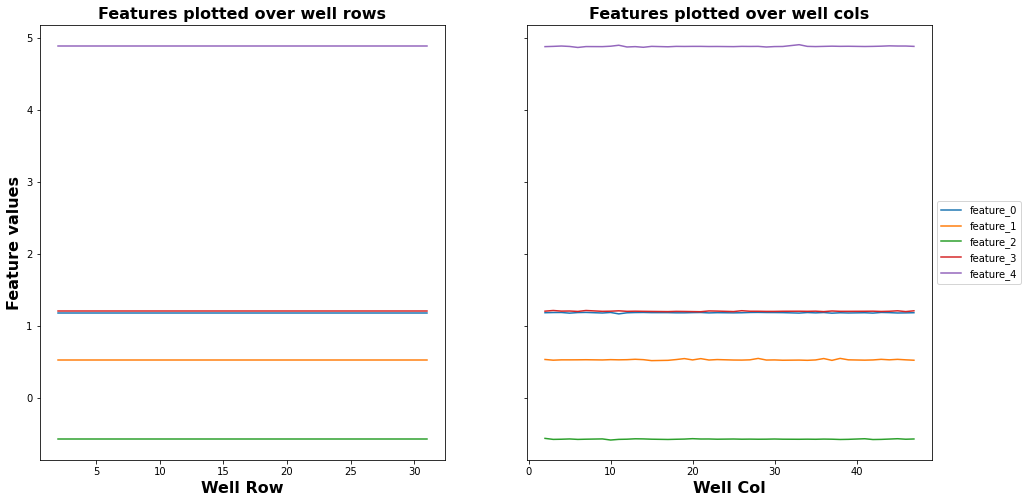

In [169]:
data = df.loc[exp1,:].loc[all_active,:]
groups = ['well_row', 'well_col']

data = data.groupby(level=groups).median()
_, ax = plt.subplots(1,2,figsize=(16,8), sharey=True)

for (curr_ax, group) in zip(ax, groups):

  plt.sca(curr_ax)
  feats = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4']
  data.loc[:,feats].groupby(level=group).median().plot.line(ax=curr_ax);
  plt.xlabel(group.replace('_', ' ').title(), 
             fontdict={'weight': 'bold', 'size': 16});
  plt.ylabel('Feature values', 
             fontdict={'weight': 'bold', 'size': 16});
  plt.title('Features plotted over ' + group.replace('_', ' ') + 's', 
            fontdict={'weight': 'bold', 'size': 16});
  curr_ax.get_legend().remove()

ax[-1].legend(loc='center left', 
             bbox_to_anchor=(1, 0.5));

## Quantile normalization
- Within each replicated study group in each experiment, quantile normalize the feature distribution
- This approach is analogous to the Discrete method described by [Zhao et al. 2020](https://www.nature.com/articles/s41598-020-72664-6) for gene expression. Only in this case, the different features are being treated like the different genes, a "class" is a replicated treatment group or control group, and the batch is the experiment.

In [171]:
# Get rid of multi-index for this section - bogs down loop
df_vals = df.reset_index(['well_id', 'samp_group'])\
            .reset_index(drop=True)\
            .set_index(['well_id', 'samp_group'])
df_ranks = df.reset_index('well_id')\
             .reset_index(drop=True)\
             .set_index('well_id')

# Sort the feature values within each sample
df_vals.values.sort(axis=1)

# Get the mean feature value of each rank within each study group 
df_vals = df_vals.groupby('samp_group').mean()\
                 .set_axis(range(1,df_vals.shape[1]+1), axis=1)
    
# Matrix of ranks to put the mean values back in the right places
df_ranks = df_ranks.rank(axis=1, method='first')
df_ranks, _ = df_ranks.align(metadata,axis=0) # realign before loop

# For each sample group, map means to feature values based on rank (vectorized methods were too memory heavy)
new_vals = df_ranks.copy()
for sgroup in metadata.samp_group.unique():
  vals = df_vals.loc[sgroup,:]
  mask = metadata.samp_group == sgroup
  ranks = df_ranks.loc[mask,:]
  new_vals.loc[ranks.index,:] = ranks.stack().astype(int).map(vals).unstack()

# Reassign to main df
df, _ = new_vals.align(df, level='well_id')
df = df.reorder_levels(idx_order)


# Standardize the Data before PCA


In [172]:
# Standardize the data within each feature before PCA
#   For each experiment, treat the negative and positive control data as "training" data and the rest as "test" data 

for exp in metadata.experiment.unique():

  ctrl_idx = idx[['neg_ctrl', 'pos_ctrl'],:,:,:, exp]
  tx_idx = idx['treated',:,:,:, exp]
  # Instantiate scaler
  scaler = StandardScaler()
  # Fit and transform based on the controls in this experiment
  df.loc[ctrl_idx] = scaler.fit_transform(df.loc[ctrl_idx])
  # Transform the remaining treatment groups in this experiment
  df.loc[tx_idx] = scaler.transform(df.loc[tx_idx])

# PCA

In [173]:
# Do PCA to reduce feature space and create orthogonal features

# Setup PCs dataframe with new column labels
pca_feats = df.copy()
PC_n = 500 # number of PCs 
PC_cols = [''.join(tup) for tup in list(zip(['PC']*PC_n, [str(x) for x in range(1, PC_n+1)]))] # Make list of PC# columns labels
pca_feats = pca_feats.iloc[:, :PC_n]
pca_feats.rename(dict(zip(df.columns, PC_cols)), axis=1, inplace=True)

pca_idx = 0 # initial index of PCs to keep - update in for loop

# Do PCA separately for each experiment
for exp in metadata.experiment.unique():

  ctrl_idx = idx[['neg_ctrl', 'pos_ctrl'],:,:,:, exp]
  tx_idx = idx['treated',:,:,:, exp]

  # Instantiate PCA model
  pca = PCA(whiten=True, n_components=PC_n, svd_solver='full')

  # Fit and transform based on the controls in this experiment
  pca_feats.loc[ctrl_idx] = pca.fit_transform(pca_feats.loc[ctrl_idx])
  
  # Transform the remaining groups in this experiment
  pca_feats.loc[tx_idx] = pca.transform(pca_feats.loc[tx_idx])

  # Determine how many PCs to keep based on threshold of overall variance explained
  thresh = 0.99
  curr_pca_idx = pd.Series(pca.explained_variance_ratio_).cumsum().sub(thresh).abs().idxmin()
  # Just use the max number of PCs needed to explain at least thresh% variance across each experiment
  if curr_pca_idx > pca_idx:
    pca_idx = curr_pca_idx 

# Filter the PCs to keep
print('PCs kept:', pca_idx)
PC_2_keep = PC_cols[:pca_idx]
pca_feats = pca_feats[PC_2_keep]

PCs kept: 260


# Remove Outliers

In [174]:
# Remove outliers within each control group based on Mahalanobis distance and cosine similarity

pca_final = pca_feats.copy()

for exp in metadata.experiment.unique():
  exp_idx = idx[:,:,:,:, exp,:,:,:,:,:]
  for ctrl in ['neg_ctrl', 'pos_ctrl']:

    # Current ctrl and experiment
    curr = pca_final.loc[exp_idx,:].xs(ctrl, level='group', drop_level=False)
    # Calculate covariance matrices
    cov_mat = curr.cov()
    # Calculate inverse cov mat
    inv_cov = np.linalg.pinv(cov_mat)
    # Caluclate PC means
    feat_means = curr.mean()    
    # Instantiate mahal lambda funcs
    mahal_lam = lambda x: spatial.distance.mahalanobis(x, feat_means, inv_cov)
    # Calculate mahalanobis distance
    mahalD = curr.apply(mahal_lam, axis=1)
    # Calculate cutoff to define outliers
    Q1 = mahalD.quantile(0.25)
    Q3 = mahalD.quantile(0.75)
    IQR = Q3 - Q1
    cutoff = Q3 + 1.5*IQR     
    outliers_mahal = mahalD[mahalD > cutoff].index


    ## Cosine Similarity
    # Median control vector
    curr_med = curr.median()

    # Cosine similarity of each sample to the median
    cos_sim_func = lambda x: spatial.distance.cosine(curr_med, x)
    cos_sim = curr.apply(cos_sim_func, axis=1)

    # Calculate cutoff to define outliers
    Q1 = cos_sim.quantile(0.25)
    Q3 = cos_sim.quantile(0.75)
    IQR = Q3 - Q1
    cutoff_hi = Q3 + 1.5*IQR
    cutoff_lo = Q1 - 1.5*IQR      
    outliers_cos = cos_sim[(cos_sim > cutoff_hi) | (cos_sim < cutoff_lo)].index

    # Drop outliers
    outliers = outliers_cos.union(outliers_mahal)
    print('Outliers dropped for {}, {}: {:.2}%'.format(exp, ctrl, len(outliers)/len(curr)*100))
    pca_final = pca_final.drop(outliers, axis=0)
    

Outliers dropped for HRCE-1, neg_ctrl: 2.4%
Outliers dropped for HRCE-1, pos_ctrl: 3.5%
Outliers dropped for HRCE-2, neg_ctrl: 0.93%
Outliers dropped for HRCE-2, pos_ctrl: 2.9%


# Fit Classifier and Create Disease Axis

In [198]:
# Fit Classifier
#model = LogisticRegression(C=0.001, max_iter=10000)
model = LinearDiscriminantAnalysis() # Deafult LDA yields similar results to LR with regularization

# Initialize dataframes to contain results of interest
disease_scores = pd.DataFrame(index=pca_final.index, columns = ['on_disease_score', 'off_disease_score'])
Zfactor = pd.Series(index=list(metadata.experiment.unique()) + ['Overall'], dtype=float)

# Create separately for each experiment - correct for batch effect by normalizing scores between 0 and 1
for exp in metadata.experiment.unique():
  exp_idx = idx[:,:,:,:, exp,:,:,:,:,:]
  # Just use the positive and negative controls to train the classifier and then use treatment data as "test" data
  curr_data = pca_final.loc[exp_idx,:]
  ctrl_data = pca_final.loc[exp_idx,:].loc[main_ctrls,:]

  # Define the first experiment as the training set and the 2nd as the test set
  X_train = ctrl_data
  y_train = (X_train.index.get_level_values('disease_condition')=='Active').astype(int)
  
  # Fit the model and get the coeficients
  model.fit(X_train, y_train)
  print('{} Classification Accuracy: {:.3f}'.format(exp, model.score(X_train, y_train)))
  weights = model.coef_
  weights_norm = weights/np.linalg.norm(weights)
  
  # Define the disease axis as the weights from logistic regression (dot product with these weights = decision function)
  dis_vec = pd.Series(np.ravel(weights_norm), index=curr_data.columns)

  # Calculate on-disease score based on scalar projection of each well's features onto the disease axis (dis_vec)
  on_disease_score = curr_data.dot(dis_vec) # scalar projection (decision function)

  # Use Pythagorean theorem to calculate off-disease score
  off_disease_score = (curr_data.apply(np.linalg.norm, axis=1)**2 - on_disease_score**2).apply(np.sqrt)

  # Setup disease scores 
  on_disease_score.rename('on_disease_score', inplace=True)
  off_disease_score.rename('off_disease_score', inplace=True)
  curr_scores = pd.concat([on_disease_score, off_disease_score], axis=1)

  # Normalize the scores to mean=0 for neg control and mean=1 for pos control
  mean_pos = curr_scores.loc[pos_ctrl].mean()
  mean_neg = curr_scores.loc[neg_ctrl].mean()
  curr_scores['on_disease_score'] = curr_scores['on_disease_score'].apply(
      lambda x: (x - mean_neg.on_disease_score) / (mean_pos.on_disease_score - mean_neg.on_disease_score)
  )
  curr_scores['off_disease_score'] = curr_scores['off_disease_score'].apply(
      lambda x: (x - mean_neg.off_disease_score) / (mean_pos.off_disease_score - mean_neg.off_disease_score)
  )

  # Calculate the Z-factor based on the on-disease score
  sd_pos = curr_scores.loc[pos_ctrl].on_disease_score.std()
  sd_neg = curr_scores.loc[neg_ctrl].on_disease_score.std()
  mean_pos = curr_scores.loc[pos_ctrl].on_disease_score.mean() # need to recalculate means after transform
  mean_neg = curr_scores.loc[neg_ctrl].on_disease_score.mean()
  Zfactor.loc[exp] = 1 - 3*(sd_neg + sd_pos)/np.abs(mean_pos - mean_neg)

  # Update the disease scores dataframe
  disease_scores.loc[exp_idx] = curr_scores

# Calculate the overall Z-factor across experiments (assuming poolability)
sd_pos = disease_scores.loc[pos_ctrl].on_disease_score.std()
sd_neg = disease_scores.loc[neg_ctrl].on_disease_score.std()
mean_pos = disease_scores.loc[pos_ctrl].on_disease_score.mean()
mean_neg = disease_scores.loc[neg_ctrl].on_disease_score.mean()
Zfactor.loc['Overall'] = 1 - 3*(sd_neg + sd_pos)/np.abs(mean_pos - mean_neg)

HRCE-1 Classification Accuracy: 1.000
HRCE-2 Classification Accuracy: 0.999


# Evaluate the Disease Model

## Overlay of disease axes for both experiments

Z-factors for each experiment:
HRCE-1: 0.547
HRCE-2: 0.467
Overall: 0.509


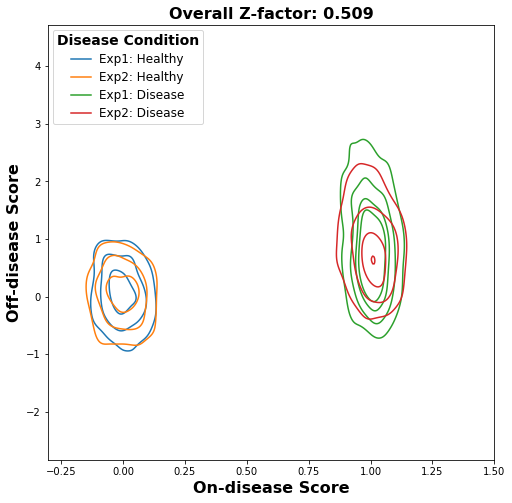

In [176]:
# Plot the controls and experiments to qualitatively examine agreement between experiments
plt.figure(figsize=(8,8));

print('Z-factors for each experiment:')
for ii in range(len(Zfactor)):
  print('{}: {:.3f}'.format(Zfactor.index[ii], Zfactor[ii]))
fig = sns.kdeplot(x='on_disease_score', 
                  y='off_disease_score', 
                  data=disease_scores.loc[main_ctrls].reset_index(), 
                  hue=disease_scores.loc[main_ctrls].reset_index().loc[:,['experiment', 'disease_condition']].apply(tuple, axis=1), 
                  levels=[0.25, 0.5, 0.75, 0.9]);
plt.xlabel('On-disease Score', 
           fontdict={'weight': 'bold', 'size': 16});
plt.xticks(np.arange(-0.25, 1.75, 0.25));
plt.ylabel('Off-disease Score', 
           fontdict={'weight': 'bold', 'size': 16});
plt.title('Overall Z-factor: {:.3f}'.format(Zfactor.loc['Overall']), 
          fontdict={'weight': 'bold', 'size': 16});

sns.move_legend(fig, loc='upper left')

# Update legend
lgnd = fig.get_legend()
lgnd.set_title('Disease Condition');
new_labels = ['Exp1: Healthy', 
              'Exp2: Healthy', 
              'Exp1: Disease', 
              'Exp2: Disease']
for t, l in zip(lgnd.texts, new_labels):
    t.set_text(l);
plt.setp(lgnd.get_texts(), fontsize='12');
plt.setp(lgnd.get_title(), fontsize='14', fontweight='bold');

## Pooled Disease Model

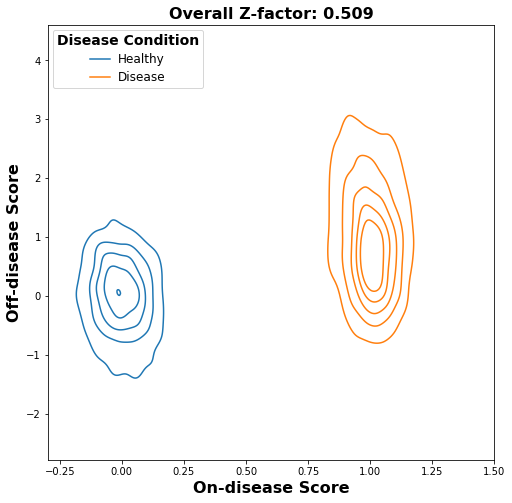

In [177]:
# Overlap looks good above, plot the two experiments together (assumes batch effects sufficiently removed)
plt.figure(figsize=(8,8));
fig = sns.kdeplot(x='on_disease_score', 
                  y='off_disease_score', 
                  data=disease_scores.loc[main_ctrls].reset_index(), 
                  hue='disease_condition', 
                  levels=[0.1, 0.3, 0.5, 0.7, 0.9], 
                  hue_order=['Inactive', 'Active'], 
                  legend=True);
plt.xlabel('On-disease Score', 
           fontdict={'weight': 'bold', 'size': 16});
plt.xticks(np.arange(-0.25, 1.75, 0.25));
plt.ylabel('Off-disease Score', 
           fontdict={'weight': 'bold', 'size': 16});
plt.title('Overall Z-factor: {:.3f}'.format(Zfactor.loc['Overall']), 
          fontdict={'weight': 'bold', 'size': 16});

sns.move_legend(fig, loc='upper left')

# Update legend
lgnd = fig.get_legend()
lgnd.set_title('Disease Condition');
new_labels = ['Healthy', 'Disease']
for t, l in zip(lgnd.texts, new_labels):
    t.set_text(l);
plt.setp(lgnd.get_texts(), fontsize='12');
plt.setp(lgnd.get_title(), fontsize='14', fontweight='bold');
    

## Distributions of On-disease scores for each experiment

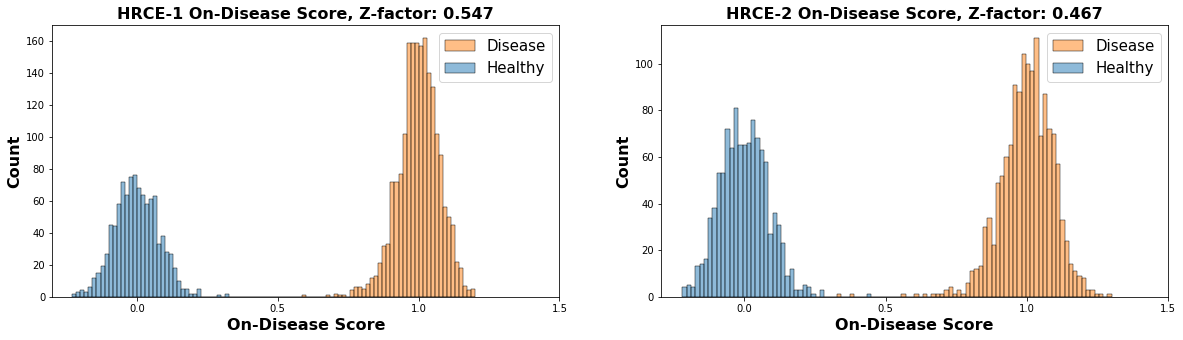

In [178]:
# Plot the on-disease and off-disease scores for each control, separately for the two experiments
fig, ax = plt.subplots(1,2, figsize=(20,5))
for (curr_ax, exp) in zip(ax, metadata.experiment.unique()):
  exp_idx = idx[:,:,:,:, exp]
  plt.sca(curr_ax)
  data = disease_scores.loc[exp_idx].loc[main_ctrls]
  sns.histplot(data=data, 
               x='on_disease_score', 
               hue='disease_condition', 
               bins=100, 
               hue_order=['Inactive', 'Active']);
  plt.title(exp + ' On-Disease Score, Z-factor: {:.3f}'.format(Zfactor[exp]), 
            fontdict={'weight': 'bold', 'size': 16});
  plt.xlabel('On-Disease Score', 
             fontdict={'weight': 'bold', 'size': 16});
  plt.ylabel('Count', 
             fontdict={'weight': 'bold', 'size': 16})
  plt.xticks([0, 0.5, 1, 1.5]);
  plt.legend(['Disease', 'Healthy'], 
             prop={'size':15});



# Comparison of consistency across experiments

## Experiment 1 vs. Experiment 2

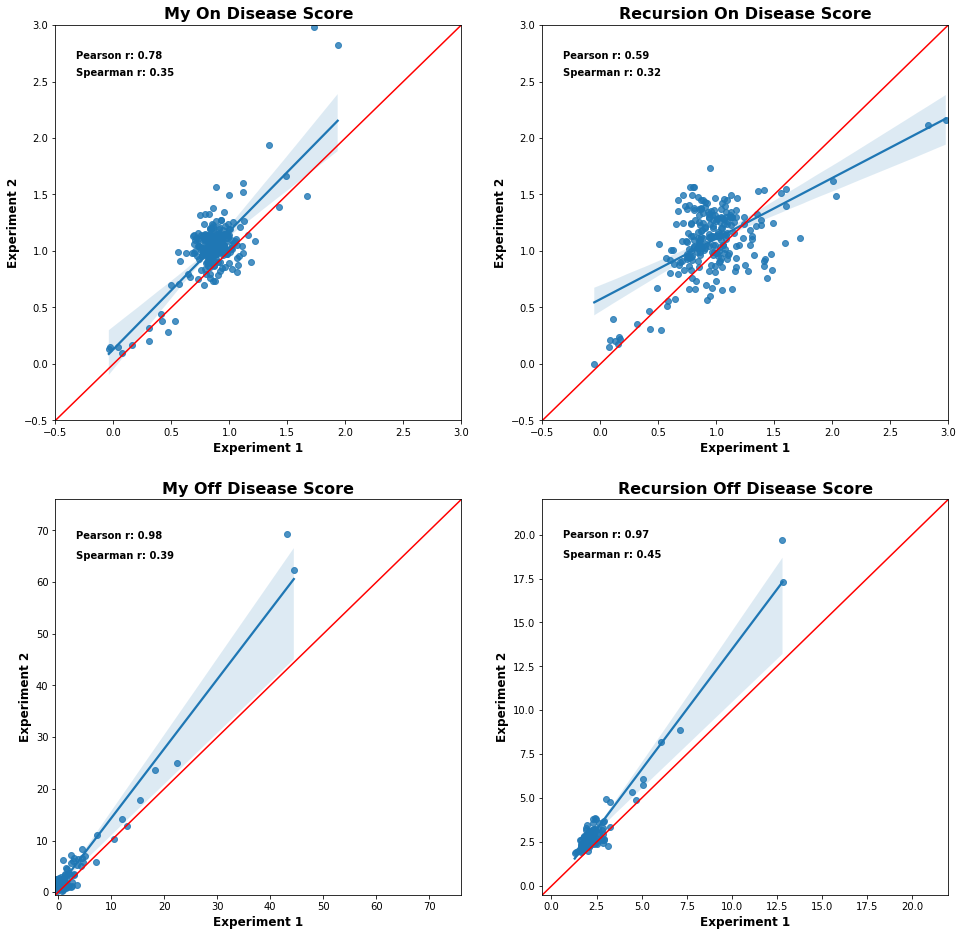

In [179]:
# Import Recursion's results data
rx_disease_scores = pd.read_csv('/Volumes/GoogleDrive/My Drive/Colab Notebooks/Recursion COVID/COVID_disease_scores.csv')
rx_hit_scores = pd.read_csv('/Volumes/GoogleDrive/My Drive/Colab Notebooks/Recursion COVID/COVID_hit_scores.csv')
rx_disease_scores.replace({'COVID19-launchedp1-HRCE-X-b-20x': 'HRCE-1', 'COVID19-launchedp2-HRCE-X-b-20x': 'HRCE-2'}, inplace=True)
rx_disease_scores = rx_disease_scores[(rx_disease_scores.experiment!='COVID19-reference-VERO-48-a-20x') & (rx_disease_scores.experiment!='COVID19-reference-VERO-48-b-20x')]
rx_hit_scores.replace({'COVID19-launchedp1-HRCE-X-b-20x': 'HRCE-1', 'COVID19-launchedp2-HRCE-X-b-20x': 'HRCE-2'}, inplace=True)
rx_hit_scores = rx_hit_scores[(rx_hit_scores.experiment!='COVID19-reference-VERO-48-a-20x') & (rx_hit_scores.experiment!='COVID19-reference-VERO-48-b-20x')]

# Plot the scores from the two experiments against each other to examine correlation

my_summary = disease_scores.loc[treated].groupby(level=['experiment', 'treatment', 'treatment_conc'])[['on_disease_score', 'off_disease_score']].median().dropna()
my_data = my_summary.loc['HRCE-1'].join(my_summary.loc['HRCE-2'], rsuffix='_2', how='inner')
rx_summary = rx_disease_scores.groupby(['experiment', 'treatment', 'treatment_conc'])[['on_disease_score', 'off_disease_score']].median()
rx_data = rx_summary.loc['HRCE-1'].join(rx_summary.loc['HRCE-2'], rsuffix='_2', how='inner')
rx_data.dropna(axis=0, inplace=True)

_, ax = plt.subplots(2,2, figsize=(16,16))

on_scores = ['on_disease_score', 'on_disease_score_2']
off_scores = ['off_disease_score', 'off_disease_score_2']

for ii, score in enumerate([on_scores, off_scores]):
  for jj, data in enumerate([my_data, rx_data]):

    data0 = data[score[0]].dropna()
    data1 = data[score[1]].dropna()

    pear_r, _ = stats.pearsonr(data0, data1)
    spear_r, _ = stats.spearmanr(data0, data1)

    plt.sca(ax[ii,jj])
    sns.regplot(x=data0, y=data1)
    
    min_lim = -0.5
    max_lim = round(max(max(data1), max(data0))*1.1)
    plt.ylim(min_lim, max_lim);
    plt.xlim(min_lim, max_lim);
    plt.plot([-100, 100], [-100, 100], 'r-');
    plt.text(min_lim+.05*(max_lim-min_lim), 
             .9*max_lim, 
             'Pearson r: {:.2f}'.format(pear_r), fontdict={'weight':'bold'});
    plt.text(min_lim+.05*(max_lim-min_lim), 
             .85*max_lim, 
             'Spearman r: {:.2f}'.format(spear_r), fontdict={'weight':'bold'});
    if jj==0:
      title = 'My '
    else:
      title = 'Recursion '

    plt.title(title + score[0].replace('_', ' ').title(), 
              fontdict={'weight':'bold', 'size':16});
    plt.xlabel('Experiment 1', 
               fontdict={'weight':'bold', 'size':12});
    plt.ylabel('Experiment 2', 
               fontdict={'weight':'bold', 'size':12});


### Mean-Difference plots between the 2 experiments

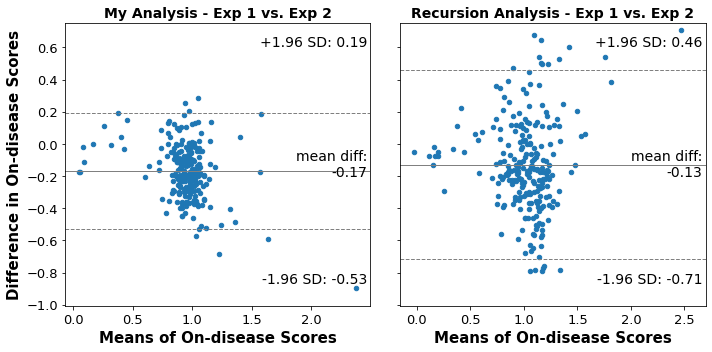

In [180]:
# Use mean-difference plots to examine agreement between the replicated HRCE experiments

_, ax = plt.subplots(1,2, figsize=(10,5), sharey=True)

for (curr_ax, data) in zip(ax, [my_data, rx_data]):

  sm.graphics.mean_diff_plot(data.on_disease_score, data.on_disease_score_2, ax=curr_ax)
  plt.sca(curr_ax)
  if data.equals(my_data):
    title = 'My '
    ylab = 'Difference in On-disease Scores'
  else:
    title = 'Recursion '
    ylab = ''
  plt.title(title + 'Analysis - Exp 1 vs. Exp 2', 
            fontdict={'weight': 'bold', 'size':14});
  plt.xlabel('Means of On-disease Scores', 
             fontdict={'weight': 'bold'});
  plt.ylabel(ylab, 
             fontdict={'weight': 'bold'});

# Evaluation of Drug Candidates

## Mean score of each treatment group

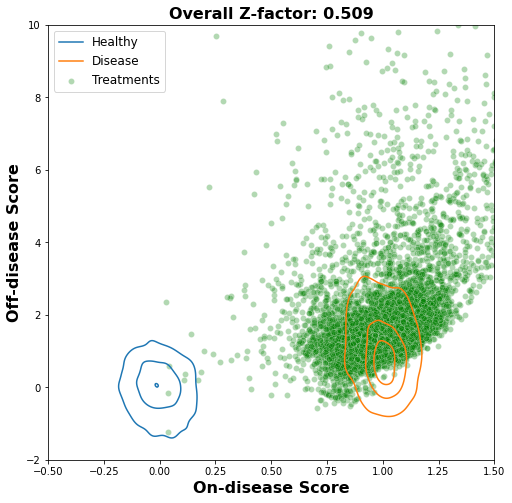

In [229]:
plt.figure(figsize=(8,8));
ax = sns.kdeplot(x='on_disease_score', 
                 y='off_disease_score', 
                 data=disease_scores.loc[main_ctrls].reset_index(), 
                 hue='disease_condition', 
                 levels=[0.1, 0.5, 0.9], 
                 hue_order=['Inactive', 'Active'], 
                 legend=True);
plt.xlabel('On-disease Score', 
           fontdict={'weight': 'bold', 'size': 16});
plt.xticks(np.arange(-0.5, 1.75, 0.25));
plt.ylabel('Off-disease Score', 
           fontdict={'weight': 'bold', 'size': 16});
plt.title('Overall Z-factor: {:.3f}'.format(Zfactor.loc['Overall']), 
          fontdict={'weight': 'bold', 'size': 16});

lgnd = ax.get_legend()
handles = lgnd.legendHandles

x = disease_scores.loc[treated]\
                  .groupby(level='samp_group')\
                  .on_disease_score.mean()
y = disease_scores.loc[treated]\
                  .groupby(level='samp_group')\
                  .off_disease_score.mean()
sns.scatterplot(x=x, 
                y=y, 
                color='green', 
                alpha=0.3, 
                label='Treatments',
                ax=ax);
plt.xlim(-0.5, 1.5);
plt.ylim(-2, 10);

handles2, labels2 = ax.get_legend_handles_labels()
plt.legend(prop={'size':12},
           handles=handles+handles2, 
           labels=['Healthy', 'Disease']+labels2)
sns.move_legend(fig, loc='upper left')

## Visualize some treatments that were in both experiments

The treatment data looks a bit noisy, which suggests that the normalization methods could be improved still. I'd expect the low drug concentrations to cluster better within the area of the Disease control.

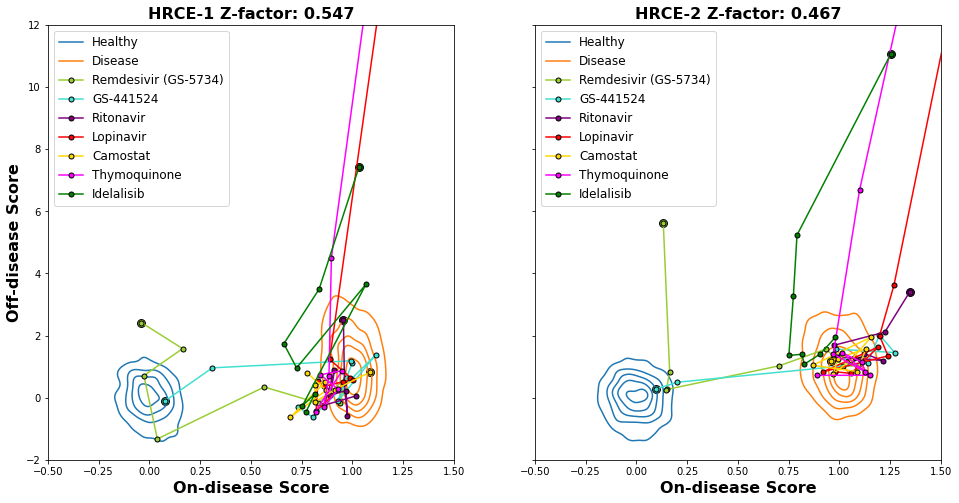

In [226]:
treatments = ['Remdesivir (GS-5734)', 'GS-441524', 'Ritonavir', 'Lopinavir', 'Camostat',  'Thymoquinone', 'Idelalisib']
colors = ['yellowgreen', 'turquoise', 'purple', 'red', 'gold', 'magenta', 'green']

_, ax = plt.subplots(1,2, figsize=(16,8), sharey=True);

for (curr_ax, exp) in zip(ax, metadata.experiment.unique()):
  exp_idx = idx[:,:,:,:, exp]
  plt.sca(curr_ax)
  data = disease_scores.loc[exp_idx].loc[main_ctrls]
  sns.kdeplot(x='on_disease_score', 
              y='off_disease_score', 
              data=data.reset_index(), 
              hue='disease_condition', 
              levels=[0.1, 0.3, 0.5, 0.7, 0.9], 
              hue_order=['Inactive', 'Active']);
  plt.xlabel('On-disease Score', 
             fontdict={'weight': 'bold', 'size': 16});
  plt.xticks(np.arange(-0.5, 1.75, 0.25));
  plt.ylabel('Off-disease Score', 
             fontdict={'weight': 'bold', 'size': 16});
  plt.title('{} Z-factor: {:.3f}'.format(exp, Zfactor.loc[exp]), 
            fontdict={'weight': 'bold', 'size': 16});
  plt.xlim(-0.5, 1.5);
  plt.ylim(-2, 12);

  lgnd = curr_ax.get_legend()
  handles = lgnd.legendHandles 
    
  # Plot each of the treatments and associated colors listed above
  for c, tx in zip(colors, treatments):

    data = my_summary.loc[(exp, tx)]
    plt.plot(data.on_disease_score, 
             data.off_disease_score, 
             '.-', c=c, ms=10, mec='k', 
             label=tx)
    plt.scatter(data.on_disease_score.iloc[-1], 
                data.off_disease_score.iloc[-1], 
                c=c, marker='.', s=250, ec='k', lw=1)
  

  handles2, labels2 = curr_ax.get_legend_handles_labels()        
  plt.legend(prop={'size':12},
             handles = handles + handles2, 
             labels=['Healthy', 'Disease']+labels2);

## Plot the dose-response curves for Remdesivir

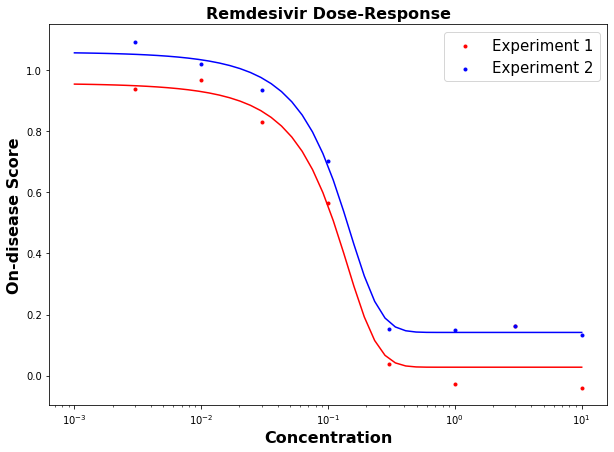

In [183]:
plt.figure(figsize=(10,7))

# Plot the data points
data1 = my_summary.loc[('HRCE-1', 'Remdesivir (GS-5734)')]
data2 = my_summary.loc[('HRCE-2', 'Remdesivir (GS-5734)')]
plt.scatter(data1.index, 
            data1.on_disease_score, 
            marker='.', c='r', 
            label='Remdesivir-1')
plt.scatter(data2.index, 
            data2.on_disease_score, 
            marker='.', c='b', 
            label='Remdesivir-2')
plt.xscale('log');
plt.ylabel('On-disease Score');
plt.xlabel('Concentration');
plt.legend();

# Fit to a generalized sigmoid function
def sigmoid(x, k, L, b, c):
  y = k / (L + np.exp(-(b*x))) + c
  return (y)

# Fit and plot the data from each experiment
coeffs1, _ = curve_fit(sigmoid, 
                       data1.index, 
                       data1.on_disease_score)  
y_pred1 = sigmoid(np.logspace(-3, 1, 50), *coeffs1)
plt.plot(np.logspace(-3, 1, 50), y_pred1, 'r');

coeffs2, _ = curve_fit(sigmoid,
                       data2.index, 
                       data2.on_disease_score)  
y_pred2 = sigmoid(np.logspace(-3, 1, 50), *coeffs2)
plt.plot(np.logspace(-3, 1, 50), y_pred2, 'b');

plt.title('Remdesivir Dose-Response', fontdict={'weight':'bold', 'size':16});
plt.xlabel('Concentration', fontdict={'weight':'bold', 'size':16});
plt.ylabel('On-disease Score', fontdict={'weight':'bold', 'size':16});
plt.legend(['Experiment 1', 'Experiment 2'], prop={'size':15});

## Hit Scores

A treatment will be considered a hit based on a 2D Gaussian kernel around the negative control group (Healthy / Inactive)
- The kernel will have mean = (0,0) and SD = 6\*SD in each disease direction since scores drop off exponentially from the mean
- Hit threshold was set as 0.7 (qualitatively selected based on visual inspection of the plot below)

In [195]:
neg_ctrl_data = disease_scores.loc[neg_ctrl, ['on_disease_score', 'off_disease_score']]
treated_data = disease_scores.loc[treated]\
                             .groupby(level='samp_group')[['on_disease_score', 'off_disease_score']].median()
labels = disease_scores.reset_index().groupby('samp_group').first()

A=1
X0=neg_ctrl_data.on_disease_score.mean()
Y0=neg_ctrl_data.off_disease_score.mean()
sig_X = neg_ctrl_data.on_disease_score.std()*6
sig_Y = neg_ctrl_data.off_disease_score.std()*6

X = treated_data.on_disease_score.astype(float)
Y = treated_data.off_disease_score.astype(float)

hitscore = A*np.exp(-( (X-X0)**2/(2*sig_X**2) + (Y-Y0)**2/(2*sig_Y**2) ) )
hitscore = hitscore.rename('hit_score')
hit_scores = labels.join(hitscore).sort_values(by='hit_score', ascending=False)

hits = hit_scores.groupby('treatment')['hit_score']\
                 .max().sort_values(ascending=False)

threshold = 0.7

print('Hits with score >= ' + str(threshold))
print(hits[hits.gt(threshold)].reset_index().to_string())

Hits with score >= 0.7
              treatment  hit_score
0             GS-441524   0.987896
1  Remdesivir (GS-5734)   0.977766
2       trihexyphenidyl   0.864741
3           Aloxistatin   0.797362


**Recursion's top 5 hits**

In [185]:
rx_hits = rx_hit_scores.groupby('treatment').hit_score.max().sort_values(ascending=False)
print(rx_hits.head(5).reset_index().to_string())

              treatment  hit_score
0  Remdesivir (GS-5734)   0.976726
1             GS-441524   0.883930
2           Aloxistatin   0.790375
3               CX-4945   0.760835
4             almitrine   0.720646


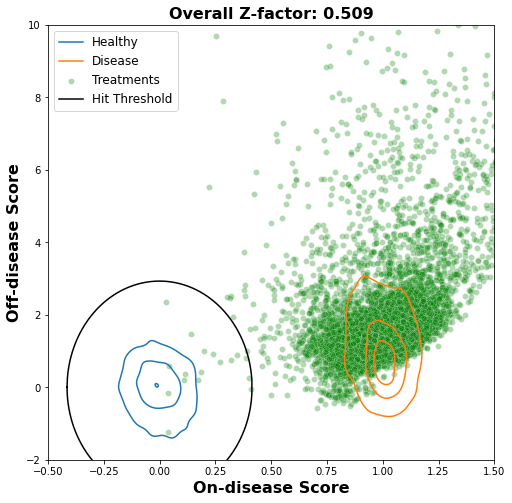

In [230]:
xlim = np.sqrt(2*sig_X**2*(- np.log(threshold)))
x = np.arange(-xlim, xlim, 2*xlim/1000)
y1 = np.sqrt(2*sig_Y**2*(-x**2/(2*sig_X**2) - np.log(threshold)))
y2 = -np.sqrt(2*sig_Y**2*(-np.flip(x)**2/(2*sig_X**2) - np.log(threshold)))
y = np.concatenate((y1,y2, y1[0:1]))
x = np.concatenate((x,np.flip(x), x[0:1]))

fig = plt.figure(figsize=(8,8));
ax = sns.kdeplot(x='on_disease_score', 
                  y='off_disease_score', 
                  data=disease_scores.loc[main_ctrls].reset_index(), 
                  hue='disease_condition', 
                  levels=[0.1, 0.5, 0.9], 
                  hue_order=['Inactive', 'Active']);
plt.xlabel('On-disease Score', 
           fontdict={'weight': 'bold', 'size': 16});
plt.xticks(np.arange(-0.5, 1.75, 0.25));
plt.ylabel('Off-disease Score', 
           fontdict={'weight': 'bold', 'size': 16});
plt.title('Overall Z-factor: {:.3f}'.format(Zfactor.loc['Overall']), 
          fontdict={'weight': 'bold', 'size': 16});

lgnd = ax.get_legend()
handles = lgnd.legendHandles

x_treat = disease_scores.loc[treated]\
                        .groupby(level='samp_group')\
                        .on_disease_score.mean()
y_treat = disease_scores.loc[treated]\
                        .groupby(level='samp_group')\
                        .off_disease_score.mean()
sns.scatterplot(x=x_treat, 
                      y=y_treat, 
                      color='green', 
                      alpha=0.3, 
                      label='Treatments',
                      ax=ax);


plt.plot(x, y, c='k', label='Hit Threshold')

handles2, labels2 = ax.get_legend_handles_labels()
plt.legend(prop={'size':12},
           handles = handles + handles2, 
           labels=['Healthy', 'Disease']+labels2);
plt.xlim(-0.5, 1.5);
plt.ylim(-2, 10);

## Dose-response of the top hit candidates

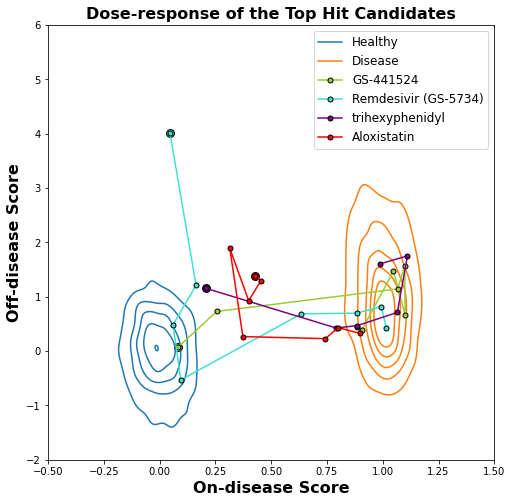

In [233]:

treatments = hits[hits.gt(threshold)].reset_index().treatment
colors = ['yellowgreen', 'turquoise', 'purple', 'red', 'gold', 'magenta', 'green']

plt.figure(figsize=(8,8));
ax = sns.kdeplot(x='on_disease_score', 
                 y='off_disease_score', 
                 data=disease_scores.loc[main_ctrls].reset_index(), 
                 hue='disease_condition', 
                 levels=[0.1, 0.3, 0.5, 0.7, 0.9], 
                 hue_order=['Inactive', 'Active']);
plt.xlabel('On-disease Score', 
           fontdict={'weight': 'bold', 'size': 16});
plt.xticks(np.arange(-0.5, 1.75, 0.25));
plt.ylabel('Off-disease Score', 
           fontdict={'weight': 'bold', 'size': 16});
plt.xlim(-0.5, 1.5);
plt.ylim(-2, 6);

lgnd = ax.get_legend()
handles = lgnd.legendHandles

# Plot each of the treatments and associated colors listed above
for c, tx in zip(colors, treatments):
    data = my_summary.loc[idx[:,tx], :]\
                     .groupby(['treatment', 'treatment_conc'])\
                     .mean()
    plt.plot(data.on_disease_score, 
             data.off_disease_score, 
             '.-', c=c, ms=10, mec='k',
             label=tx)
    plt.scatter(data.on_disease_score[-1], 
                data.off_disease_score[-1], 
                c=c, marker='.', s=250, ec='k', lw=1)

handles2, labels2 = ax.get_legend_handles_labels()    
    
plt.legend(prop={'size':12},
          handles = handles + handles2, 
          labels=['Healthy', 'Disease']+labels2);

plt.title('Dose-response of the Top Hit Candidates',
         fontdict={'weight':'bold', 'size':16});